<div class="clearfix" style="padding: 10px; padding-left: 0px">
<img src="https://raw.githubusercontent.com/jupyter/nature-demo/master/images/jupyter-logo.png" width="150px" style="display: inline-block; margin-top: 5px;">
<a href="http://bit.ly/tmpnbdevrax"><img src="https://cloud.githubusercontent.com/assets/836375/4916141/2732892e-64d6-11e4-980f-11afcf03ca31.png" width="150px" class="pull-right" style="display: inline-block; margin: 0px;"></a>
</div>

## Welcome to the Temporary Notebook (tmpnb) service!

This Notebook Server was **launched just for you**. It's a temporary way for you to try out a recent development version of the IPython/Jupyter notebook.

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>**WARNING**</p>

<p>Don't rely on this server for anything you want to last - your server will be *deleted after 10 minutes of inactivity*.</p>
</div>

Your server is hosted thanks to [Rackspace](http://bit.ly/tmpnbdevrax), on their on-demand bare metal servers, [OnMetal](http://bit.ly/onmetal).


### Run some Python code!

To run the code below:

1. Click on the cell to select it.
2. Press `SHIFT+ENTER` on your keyboard or press the play button (<button class='fa fa-play icon-play btn btn-xs btn-default'></button>) in the toolbar above.

A full tutorial for using the notebook interface is available [here](ipython_examples/Notebook/Index.ipynb).

In [42]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib
import datetime

from matplotlib import pyplot as plt
import seaborn as sns

# ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))
# ts = ts.cumsum()

# df = pd.DataFrame(np.random.randn(1000, 4), index=ts.index,
#                   columns=['A', 'B', 'C', 'D'])
# df = df.cumsum()
# df.plot(); plt.legend(loc='best')

In [23]:
df = pd.concat([pd.read_csv('PoolHeaterPhoton' + f, names=['event_name','event','photon','day'], usecols=['event','day'], parse_dates=['day']) for f in ['.csv', '1.csv', '2.csv']])
df.head()

,event,day
0,off,2017-11-19 10:00:00
1,on,2017-11-19 10:38:00
2,off,2017-11-19 10:56:00
3,off,2017-11-19 11:04:00
4,on,2017-11-19 10:58:00


In [27]:
df = df.sort_values(by=['day'])
df.head()

,event,day
0,off,2017-11-19 10:00:00
1,on,2017-11-19 10:38:00
2,off,2017-11-19 10:56:00
4,on,2017-11-19 10:58:00
3,off,2017-11-19 11:04:00


In [73]:
last = pd.to_datetime(np.nan)
def elapsed(row):
    global last
    if row.event == 'off':
        return row.day - last
    else:
        last = row.day
        return row.day-last

df['elapsed'] = df.apply(elapsed,axis=1)
df.head()
df.dtypes

event               object
day         datetime64[ns]
elapsed    timedelta64[ns]
dtype: object

In [82]:
len(df[df.elapsed < datetime.timedelta(minutes=0)])

0

In [186]:
pf = df
pf = pf[(pf['event'] == 'off')]
pf = pf[~pf['elapsed'].isnull()]
pf = pf[pf.elapsed < datetime.timedelta(minutes=70)]
pf['elapsed'] = pf['elapsed'].astype('timedelta64[s]')

In [187]:
def rate_type(row):
    cost_type = ""
    # http://www.torontohydro.com/SITES/ELECTRICSYSTEM/BUSINESS/RATES/Pages/busrates.aspx
    hour = int(row.day.hour)
    if (row.day.weekday() >= 5) or \
        (hour >= 19) or \
        (hour < 8):
        #off peak
        cost_type = 'off_peak' #6.5 #cents/kWh
    elif (7 <= hour < 11) or \
         (17 <= hour < 19):
         #high peak
         cost_type = 'high_peak' #13.2 #cents/kWh
    else:
        #mid peak
        cost_type = 'mid_peak' #9.5 #cents/kWh
    #duration = (row.elapsed / 3600) # hours
    return cost_type

heater = 57 # kW

pf = pf.reset_index(drop=True)
pf['cost_type'] = pf.apply(rate_type,axis=1)
pf['cost'] = 0
pf.ix[pf['cost_type'] == 'off_peak', 'cost'] = (pf['elapsed'] / 3600) * heater * 6.5
pf.ix[pf['cost_type'] == 'mid_peak', 'cost'] = (pf['elapsed'] / 3600) * heater * 9.5
pf.ix[pf['cost_type'] == 'high_peak', 'cost'] = (pf['elapsed'] / 3600) * heater * 13.2

In [188]:
pl = pf
pl = pl.set_index('day')
pl = pl.groupby(pd.Grouper(freq='D')).sum()

<IPython.core.display.Javascript object>


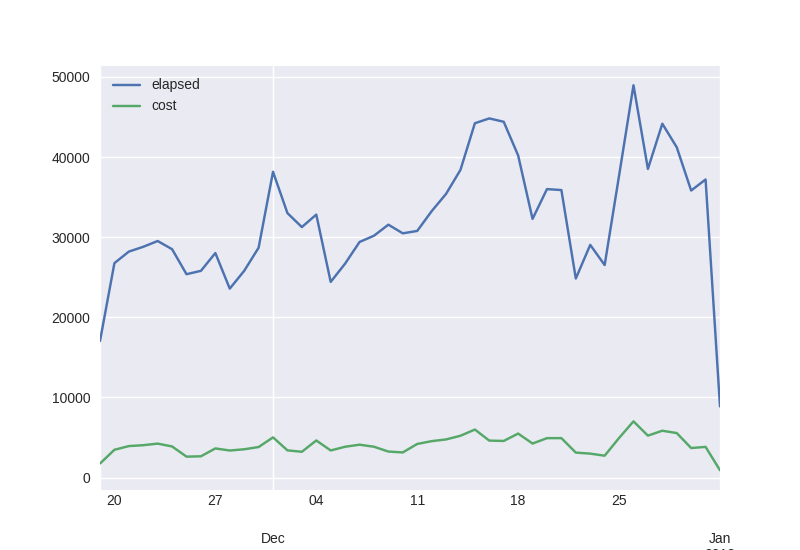

In [189]:
pl[['elapsed','cost']].plot()

In [190]:
#cost for the period
pf.cost.sum()/100

1780.9355499999999

In [191]:
# cost per day
(pf.cost.sum()/100)/(max(pf.day)-min(pf.day)).days

42.40322738095238

In [192]:
# approx cost for a year
((pf.cost.sum()/100)/(max(pf.day)-min(pf.day)).days)*365

15477.177994047619

In [193]:
#pump cost per year
pump = 1.4914 # kW - 2 horsepower
weekdays = 365 - 104
pump_op = 104*24*6.5 * pump
pump_op += weekdays * 12 * 6.5 * pump
pump_md = weekdays * 6 * 9.5 * pump
pump_hp = weekdays * 6 * 13.2 * pump
pump_cost = pump_op + pump_md + pump_hp
pump_cost/100

1075.7498028

Feel free to open new cells using the plus button (<button class='fa fa-plus icon-plus btn btn-xs btn-default'></button>), or hitting shift-enter while this cell is selected.

Behind the scenes, the software that powers this is [tmpnb](https://github.com/jupyter/tmpnb), a  Tornado application that spawns [pre-built Docker containers](https://github.com/ipython/docker-notebook) and then uses the [jupyter/configurable-http-proxy](https://github.com/jupyter/configurable-http-proxy) to put your notebook server on a unique path.